The alternative routing system is simulated using a discrete-event simulation based on the Gillespie algorithm for continuous-time Markov processes. This method models the system's evolution from one event to the next without fixed time steps.

Initialisation:
*   Set the simulation time $t = 0$.
*   Initialise the state of the network. With $K$ nodes, there are $K(K-1)/2$ links. The number of active calls on each of these links is set to $0$.
*   Initialise the cumulative count of blocked calls to $0$.

Main simulation loop over each event:
* The arrival rate for each of the pairs of nodes is $\nu$. Thus the total arrival rate at which new calls are attempted is $2k\nu$. The departure rate is $1$ so the total departure rate is equal to the total number of active calls across all links. The total system rate is the sum of the arrival and departure rates.
*   The time until the next event is an exponential random variable $\lambda$. Advance the clock by $\Delta t = -\log U / \lambda$, where $U$ is a uniform random number in $(0, 1)$.
*   A random number is drawn to decide whether an arrival or departure occurs.

* If we have an arrival:
    *   A pair of nodes is chosen uniformly at random.
    *   The direct link is checked. If its current call count is less than $C$, then the call is routed, and the link's count is incremented.
    *   If the direct link is full, then an alternative route is attempted through a random intermediate node $c$ chosen randomly from $K-2$ nodes.
    *   If the double link has capacity, then the call is routed, and the call counts on both links are incremented.
    *   If the alternative route also fails, then the call is blocked, and the cumulative blocked call counter is incremented.

*   If we have a departure:
i. One active call must be chosen to be terminated. This is done by selecting a call uniformly at random from the set of all currently active calls in the network.
ii. The link(s) associated with the chosen call have their call count decremented.
e. Record Data: Periodically (e.g., after every 10,000 events), the current simulation time and the cumulative blocked call count are recorded for later plotting.
This loop is repeated for a large number of transitions (e.g., several million) to observe the long-term behavior of the system.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

def run_alternative_routing_simulation(C, K, nu, num_transitions):
    '''
    Simulates the alternative routing system.
    Args:
        C: Capacity of each link.
        K: Number of nodes in the complete graph.
        nu: Arrival rate for each pair of nodes.
        num_transitions: The total number of events to simulate.
    Returns:
        A tuple containing two lists (time_stamps, blocked_counts).
    '''
    nodes = list(range(K))
    # Create a list of all unique links, represented by sorted tuples
    links = list(itertools.combinations(nodes, 2))
    link_occupancy = {link: 0 for link in links}

    num_links = len(links)
    total_arrival_rate = num_links * nu

    time = 0.0
    total_blocked_calls = 0

    time_stamps = []
    blocked_counts = []
    recording_interval = 10000

    for event_num in range(1, num_transitions + 1):
        # Calculate total number of active calls for the departure rate
        total_active_calls = sum(link_occupancy.values())

        # Total event rate for the whole system
        total_event_rate = total_arrival_rate + total_active_calls

        if total_event_rate == 0: # Should only happen at the start
            time_step = 0
        else:
            # Advance time
            time_step = np.random.exponential(1 / total_event_rate)
        time += time_step

        # Determine event type (Arrival or Departure)
        is_arrival = np.random.rand() < (total_arrival_rate / total_event_rate)

        if is_arrival:
            start_node, end_node = random.choice(links)

            # Try direct link
            direct_link = (min(start_node, end_node), max(start_node, end_node))
            if link_occupancy[direct_link] < C:
                link_occupancy[direct_link] += 1
            else:
                # Try alternative route
                other_nodes = [n for n in nodes if n != start_node and n != end_node]
                intermediate_node = random.choice(other_nodes)

                link1 = (min(start_node, intermediate_node), max(start_node, intermediate_node))
                link2 = (min(intermediate_node, end_node), max(intermediate_node, end_node))

                if link_occupancy[link1] < C and link_occupancy[link2] < C:
                    link_occupancy[link1] += 1
                    link_occupancy[link2] += 1
                else:
                    # Otherwise, block
                    total_blocked_calls += 1
        else:
            if total_active_calls > 0:
                # Create a list of all active calls to choose one uniformly
                active_call_list = []
                for link, count in link_occupancy.items():
                    active_call_list.extend([link] * count)

                link_to_decrement = random.choice(active_call_list)
                link_occupancy[link_to_decrement] -= 1

        # Record data periodically
        if event_num % recording_interval == 0:
            time_stamps.append(time)
            blocked_counts.append(total_blocked_calls)
            print(f"Transitions: {event_num}/{num_transitions}, Time: {time:.2f}, Blocked: {total_blocked_calls}", end='\r')

    return time_stamps, blocked_counts

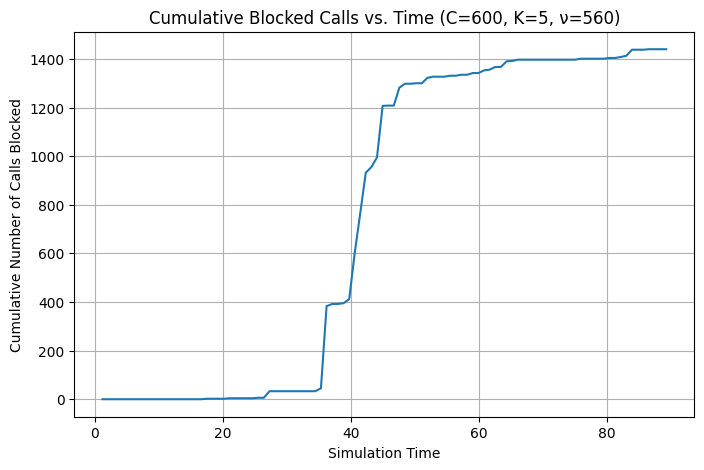

In [ ]:
C_SIM = 600
K_SIM = 5
NU_SIM = 560
TRANSITIONS = 1_000_000
times, blocked = run_alternative_routing_simulation(C_SIM, K_SIM, NU_SIM, TRANSITIONS)

plt.figure(figsize=(8, 5))
plt.plot(times, blocked, '-')
plt.title(f'Cumulative Blocked Calls vs. Time (C={C_SIM}, K={K_SIM}, ν={NU_SIM})')
plt.xlabel('Simulation Time')
plt.ylabel('Cumulative Number of Calls Blocked')
plt.grid(True)
plt.show()

The existence of multiple solutions arises from a positive feedback loop created by the alternative routing mechanism. The system can get trapped in two different self-sustaining regimes:

*   Low congestion leads to low overflow, which in turn maintains low congestion. (Low gradient).
*   High congestion leads to high overflow, which in turn maintains high congestion. (High gradient).

For a critical range of the arrival rate , both of these states are stable. If the system is in the low-blocking state, then it tends to stay there. If a random event pushes it into the high-blocking state, then the feedback loop is strong enough to keep it there for a long time.

This appears to be contrary to the theory of Markov chains that guarantees that the true, underlying Markov process has a single, unique equilibrium distribution. However, this is only a fixed point approximation to the true system. The assumption that link blocking probabilities is not strictly true. Furthermore, the low and high blocking solutions are not different equilibrium distributions.

The true Markov process does indeed have one unique equilibrium distribution. However, for the parameters that lead to multiple solutions in the approximate model, this unique distribution is bimodal.
*   One peak corresponds to the low-blocking regime.
*   The other peak corresponds to the high-blocking regime.
*   The valley between the peaks represents highly unstable, transient states.

Due to a rare sequence of random events, the approximation can jump across the valley.

---

The third solution found by solving the fixed-point equation, which lies between the low and high blocking regimes is an unstable equilibrium and is therefore not observed in practice. Consider the fixed points of the map
\begin{equation}
    B_{k+1} = f(B_k) \quad \text{where} \quad f(B) = E(\nu + 2\nu B(1 - B), C).
\end{equation}
This map describes the evolution of the blocking probability. The stability of a fixed point $f(B^*) = B$ depends on the derivative at that point. A fixed point $B^*$ is stable if $|f'(B^*)| < 1$ and unstable if $|f'(B^*)| > 1$. This can be deduced by looking at the slope of the graph.

To find the blocking probabilities for the different regimes, we must numerically find the solutions to the fixed-point equation for the parameters used in the simulation. Set $C = 600$ and $\nu = 540$. Then,
\begin{equation}
    B = E(540 + 1080B(1 - B), 600).
\end{equation}
We solve this by finding the roots of the function $g(B) = E(\nu + 2\nu B(1 - B), C) - B$.



In a network where calls are blocked if their direct link is full, each link acts as an independent Erlang link. The offered load to each link is simply the primary traffic, `ν`. The blocking probability is calculated directly with the Erlang B formula:

In conclusion, while alternative routing can offer a marginal improvement in performance under light traffic conditions (the low-blocking regime), it introduces the significant risk of the system collapsing into a highly congested, inefficient state (the high-blocking regime) from which it may struggle to recover.

In [1]:
import numpy as np
from scipy.optimize import brentq
import math
from scipy.special import gammaln, logsumexp

def erlang_b_formula(nu, C):
    if C < 0 or not isinstance(C, int):
        raise ValueError("Capacity (C) must be a non-negative integer.")
    if nu < 0:
        return 0.0
    if C == 0:
        return 1.0 if nu > 0 else 0.0
    if nu == 0:
        return 0.0
    log_terms = [
        k * np.log(nu) - gammaln(k + 1) for k in range(C + 1)
    ]
    log_numerator = C * np.log(nu) - gammaln(C + 1)
    log_denominator = logsumexp(log_terms)
    if log_denominator == -np.inf:
        return 0.0

    log_blocking_probability = log_numerator - log_denominator
    blocking_probability = np.exp(log_blocking_probability)

    return blocking_probability

def fixed_point_function(B, nu, C):
    '''
    The function whose roots are the solutions to the fixed-point equation.
    '''
    offered_load = nu + 2 * nu * B * (1 - B)
    return erlang_b_formula(offered_load, C) - B

C = 600
nu = 560
# Interval for the low-blocking solution
low_interval = (0.0, 1.0)
# Interval for the high-blocking solution
high_interval = (0.15, 0.2)

try:
    low_blocking_prob = brentq(fixed_point_function, a=low_interval[0], b=low_interval[1], args=(nu, C))
except ValueError:
    low_blocking_prob = 0.0
try:
    high_blocking_prob = brentq(fixed_point_function, a=high_interval[0], b=high_interval[1], args=(nu, C))
except ValueError:
    high_blocking_prob = 0.0
print("Probabilities for the alternative routing system:")
print(f"  Low-Blocking Regime:  {low_blocking_prob:.6f}")
print(f"  High-Blocking Regime: {high_blocking_prob:.6f}")


no_alt_routing_prob = erlang_b_formula(nu, C)

print("Probability for the System without alternative routing:")
print(f"  Direct Link Only:     {no_alt_routing_prob:.6f}")
print("Consuming two links by alternating routing is not beneficial in this case.")

Probabilities for the alternative routing system:
  Low-Blocking Regime:  0.007548
  High-Blocking Regime: 0.174550
Probability for the System without alternative routing:
  Direct Link Only:     0.004222
Consuming two links by alternating routing is not beneficial in this case.
